# Data Exploration and Preprocessing

1. **Explore Dataset**:
   - Check for class distribution and balance (positive, negative, neutral).
   
   - Basic statistical analysis (e.g., sentence length, vocabulary size).

2. **Preprocess Data**:
   - Tokenize texts using a Hugging Face tokenizer.
   
   - Create nested data splits for different training set sizes.

In [10]:
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd
import sys
import os

sys.path.append(os.path.abspath(os.path.join('../', 'src')))

from eda_preprocessing import *

In [11]:
dataset = load_dataset("stanfordnlp/sst2")
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

## 1. Explore Dataset


### 1.1 Basic Statistics


Basic Statistics for Training Set:
Average sentence length: 53.51
Max sentence length: 268
Min sentence length: 2


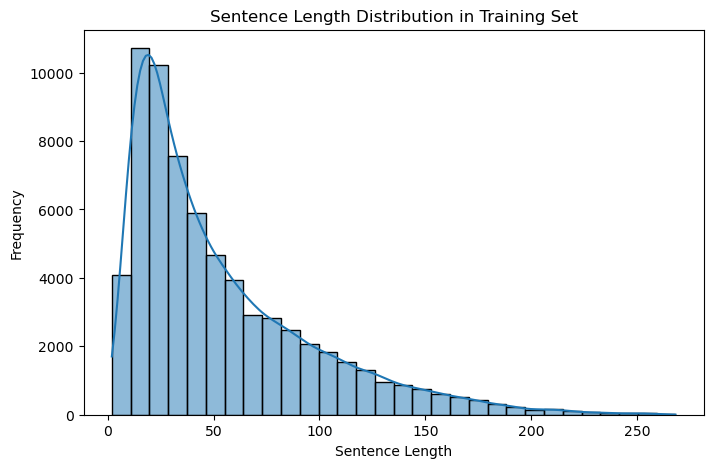


Basic Statistics for Validation Set:
Average sentence length: 105.84
Max sentence length: 244
Min sentence length: 6


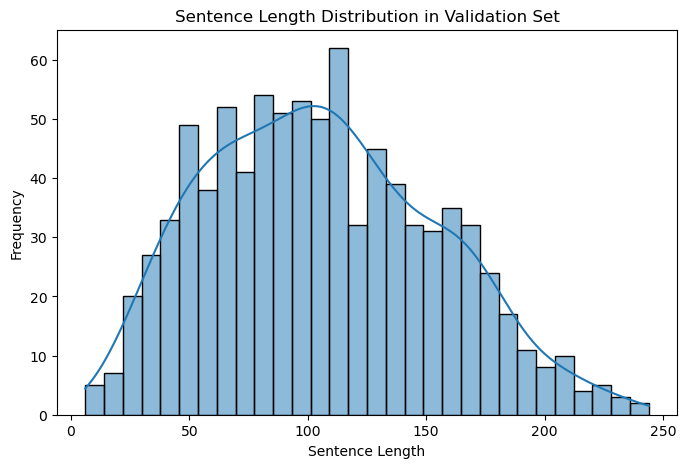


Basic Statistics for Test Set:
Average sentence length: 102.96
Max sentence length: 256
Min sentence length: 6


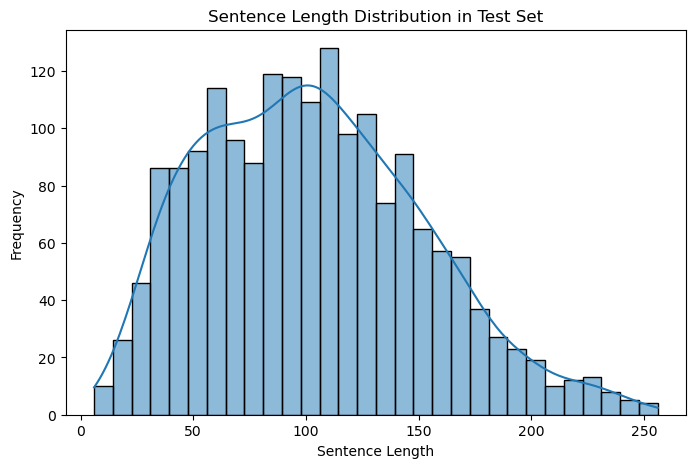

In [12]:
basic_statistics(df_train, "Training Set")
basic_statistics(df_val, "Validation Set")
basic_statistics(df_test, "Test Set")

Interesting to see that the distribution of the sentence lengths of the training set is a lot different compared to the test and validation set. The distribution of training set is more right-skewed compared to the test and validation set which are more normally distributed. This means the training set proportionally has more shorter sentences.

Why this makes sense?

### 1.2 Class Distribution

Visualizing the distribution of the classes are important to check for class imbalance, which can impact model performance.


Class Distribution in Training Set:
Label 0: 29780 samples
Label 1: 37569 samples


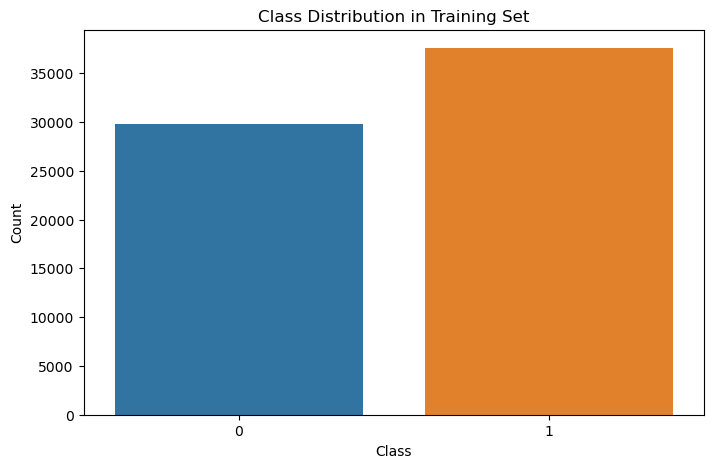


Class Distribution in Validation Set:
Label 1: 444 samples
Label 0: 428 samples


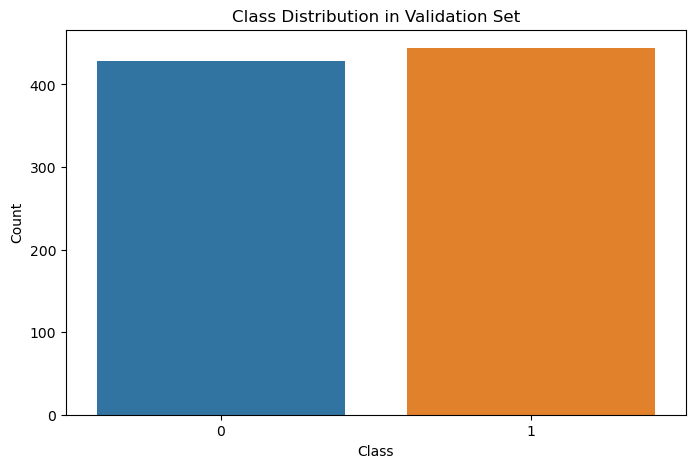


Class Distribution in Test Set:
Label -1: 1821 samples


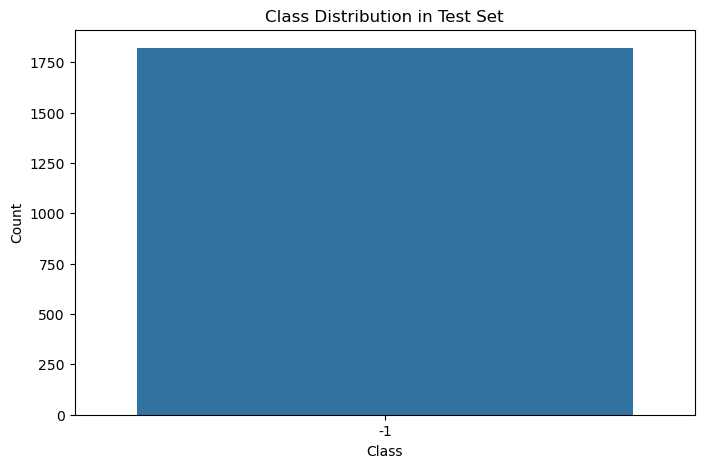

In [13]:
# Explore class distribution for training, validation, and test sets
explore_class_distribution(df_train, "Training Set")
explore_class_distribution(df_val, "Validation Set")
explore_class_distribution(df_test, "Test Set")

### 1.3 Word Length Distribution


Word Length Statistics for Training Set:
Average word count: 9.41
Max word count: 52
Min word count: 1


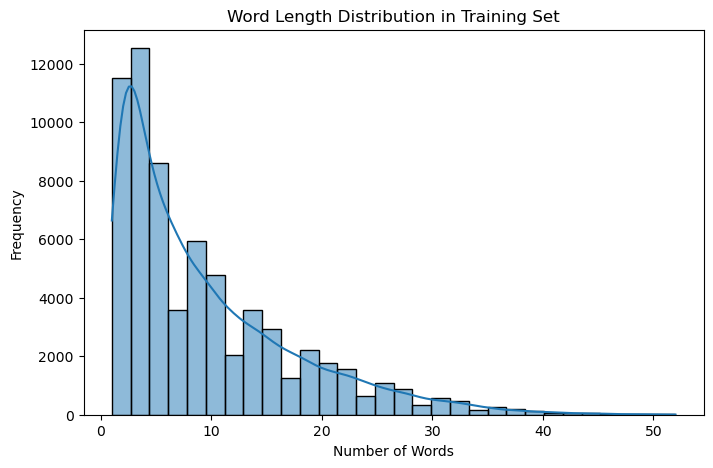


Word Length Statistics for Test Set:
Average word count: 19.23
Max word count: 56
Min word count: 2


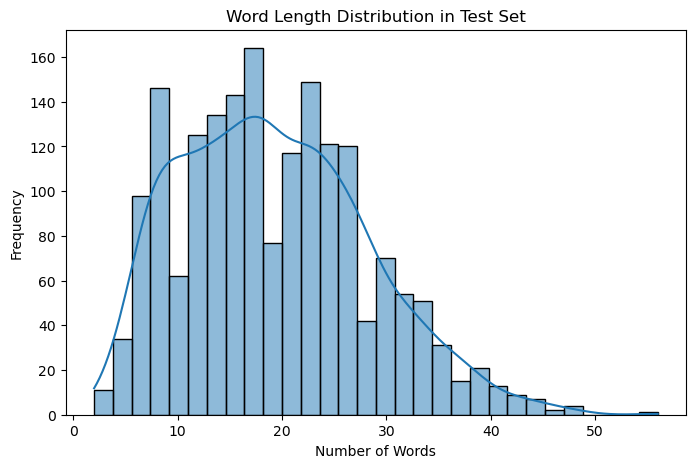


Word Length Statistics for Validation Set:
Average word count: 19.55
Max word count: 47
Min word count: 2


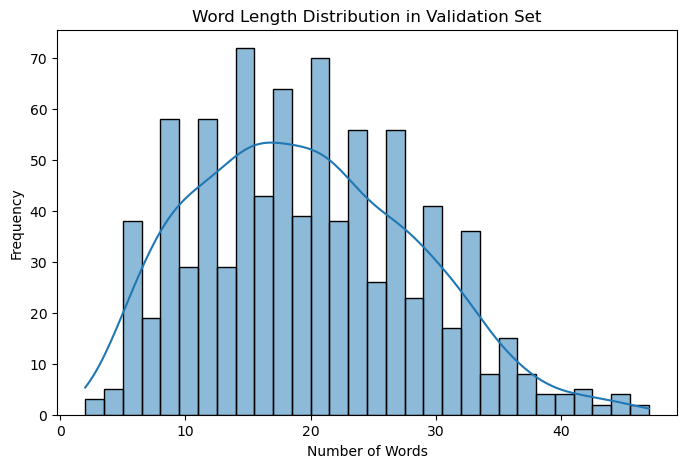

In [14]:
plot_word_length_distribution(df_train, "Training Set")
plot_word_length_distribution(df_test, "Test Set")
plot_word_length_distribution(df_val, "Validation Set")

## 2. Preprocess Data

### 2.1 Tokenize Texts

In [15]:
# Load Hugging Face tokenizer
tokenizer_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Tokenize training, validation, and test sets
train_tokens = tokenize_data(tokenizer, df_train)
val_tokens = tokenize_data(tokenizer, df_val)
test_tokens = tokenize_data(tokenizer, df_test)

### 2.2 Token Length Distribution


Token Length Statistics for Training Set:
Average token length: 13.32
Max token length: 66
Min token length: 3

Token Length Statistics for Validation Set:
Average token length: 25.16
Max token length: 55
Min token length: 4

Token Length Statistics for Test Set:
Average token length: 24.86
Max token length: 64
Min token length: 4


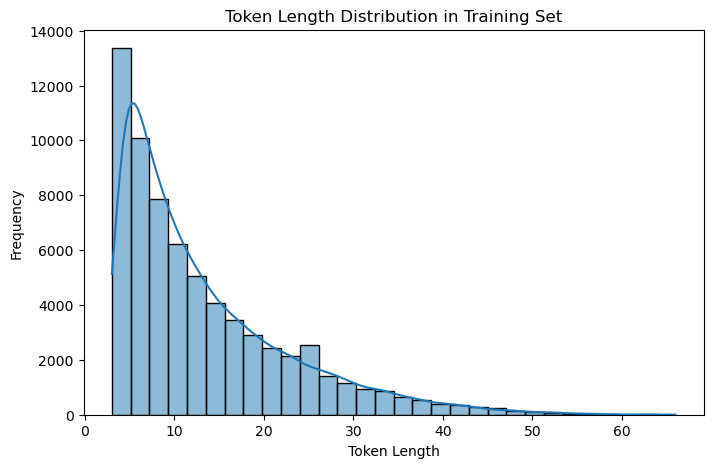

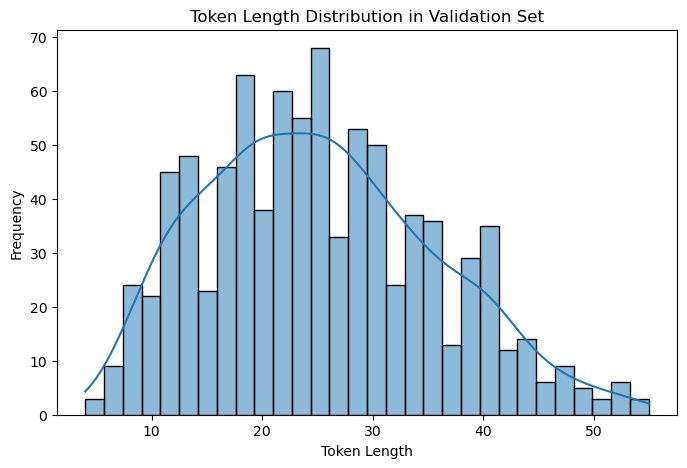

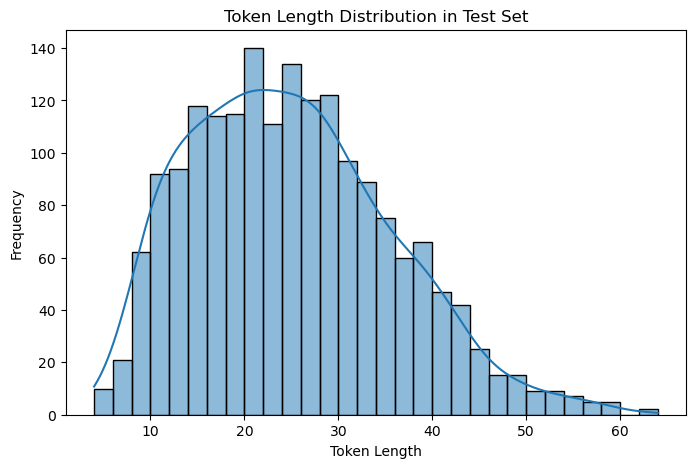

In [16]:
# Token length for training data
train_token_lengths = calculate_token_lengths(df_train, tokenizer, "Training Set")
val_tokens_lengths = calculate_token_lengths(df_val, tokenizer, "Validation Set")
test_tokens_lengths = calculate_token_lengths(df_test, tokenizer, "Test Set")

# Visualize token length distribution for the training set
plot_token_length_distribution(train_token_lengths, "Training Set")
plot_token_length_distribution(val_tokens_lengths, "Validation Set")
plot_token_length_distribution(test_tokens_lengths, "Test Set")

### 2.3 Nested Data Splits

In [17]:
split_sizes = [0.1, 0.3, 0.5, 1.0]
nested_splits = create_nested_splits(df_train, split_sizes)

data_folder = "../data/"

# Save nested splits for reproducibility
for split_name, split_data in nested_splits.items():
    split_data.to_csv(f"{data_folder}train_split_{split_name}.csv", index=False)
    print(f"Saved nested split {split_name} to train_split_{split_name}.csv")

Created split: 10% with 6734 samples.
Created split: 30% with 20204 samples.
Created split: 50% with 33674 samples.
Created split: 100% with 67349 samples.
Saved nested split 10% to train_split_10%.csv
Saved nested split 30% to train_split_30%.csv
Saved nested split 50% to train_split_50%.csv
Saved nested split 100% to train_split_100%.csv
